<a href="https://colab.research.google.com/github/prekshadhongade/Sentistock/blob/main/sentimentalanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import os
import re
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from wordcloud import WordCloud, STOPWORDS
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install matplotlib-venn


In [ ]:
stock_name = 'AMZN'


In [ ]:
all_tweets = pd.read_csv('/content/stock_tweets.csv.zip')

In [ ]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


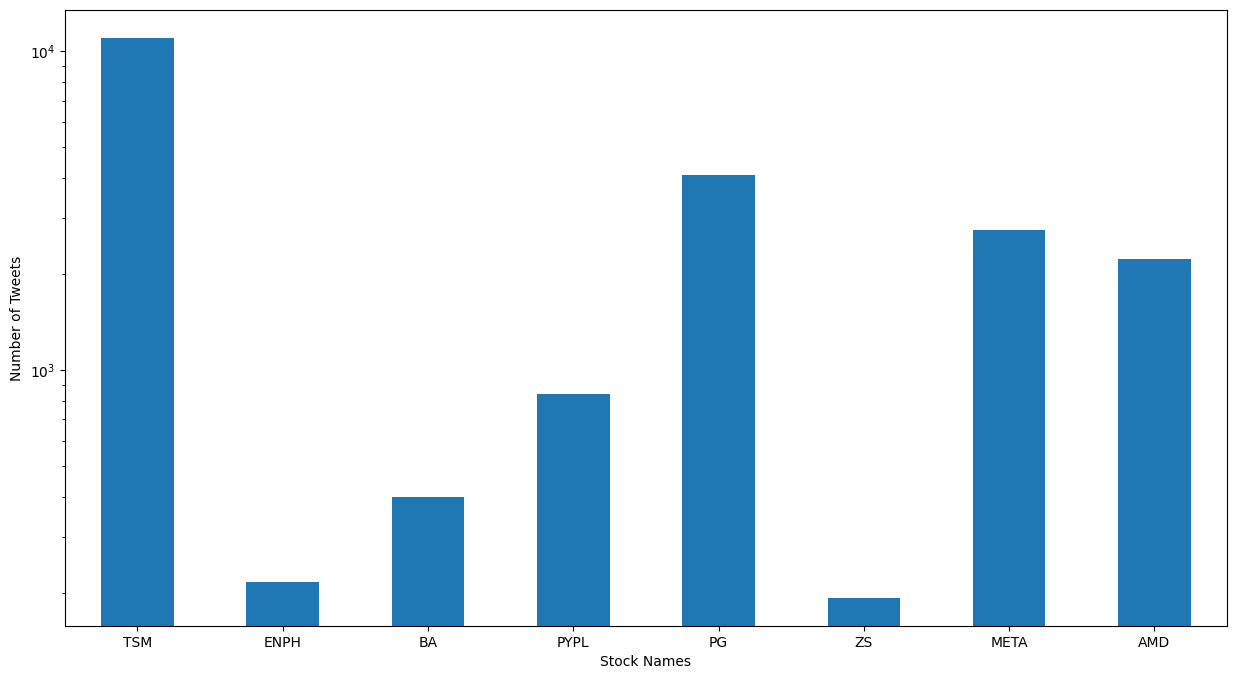

In [ ]:
# df_gb = df.groupby(['Stock Name']).size().unstack(level=2)
tmp_df = all_tweets[all_tweets['Stock Name'] != 'TSLA']
# tmp_df.groupby('Stock Name')['Stock Name'].value_counts().unstack(0).plot.barh()
xt = tmp_df.groupby(['Stock Name']).size()
xt = xt.sample(n=8)
ax = xt.plot.bar(figsize = (15,8),rot = 0, )
ax.set_xlabel("Stock Names")
ax.set_ylabel("Number of Tweets")
# ax.xaxis.label.set_size(20)
plt.yscale('log')
plt.savefig('number_of_tweets_per_stock.png')
plt.show()

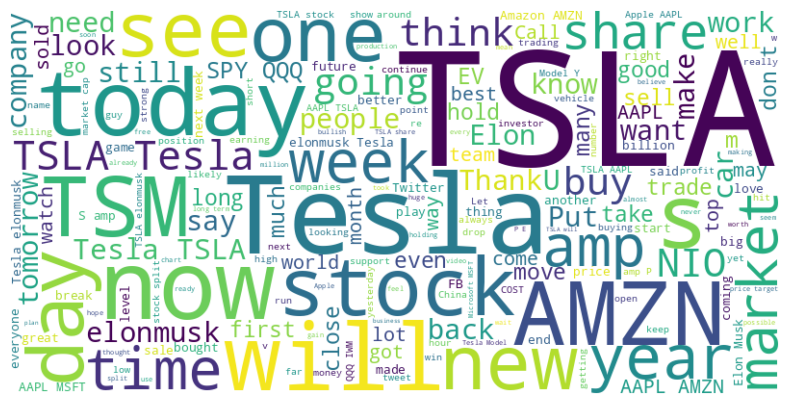

In [ ]:
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Combine all text into a single string
text = ' '.join(all_tweets['Tweet'])
text = remove_urls(text)

stopwords = set(STOPWORDS)
stopwords.update(["http", "www", "com"])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('word_cloud.png')
plt.show()

In [ ]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc."
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc."
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc."
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc."
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc."


In [ ]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",,,,


In [ ]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import unicodedata

# Initialize SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Iterate over rows in the DataFrame
for indx, row in sent_df.iterrows():
    try:
        # Normalize the Tweet text
        sentence_i = unicodedata.normalize('NFKD', row['Tweet'])

        # Calculate sentiment scores
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)

        # Assign sentiment scores to the DataFrame
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        # Handle cases where the Tweet column has invalid data
        print(sent_df.loc[indx, 'Tweet'])
        print(indx)
        break


In [ ]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",-0.0772,0.084,0.841,0.075
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",0.25,0.158,0.684,0.158
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",-0.3182,0.164,0.728,0.108
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",0.2382,0.065,0.851,0.083
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",0.7783,0.0,0.799,0.201


In [ ]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [ ]:
sent_df.head()

,Date,Tweet,sentiment_score
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,-0.0772
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,-0.3182
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,0.2382
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,0.7783


In [ ]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'], errors='coerce')


In [ ]:
twitter_df = sent_df.groupby('Date').mean(numeric_only=True)
print(twitter_df.shape)


(365, 0)


In [ ]:
twitter_df.head()


""
Date
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04


No charts were generated by quickchart


In [ ]:
all_stocks = pd.read_csv('/content/stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [ ]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 7)


In [ ]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000


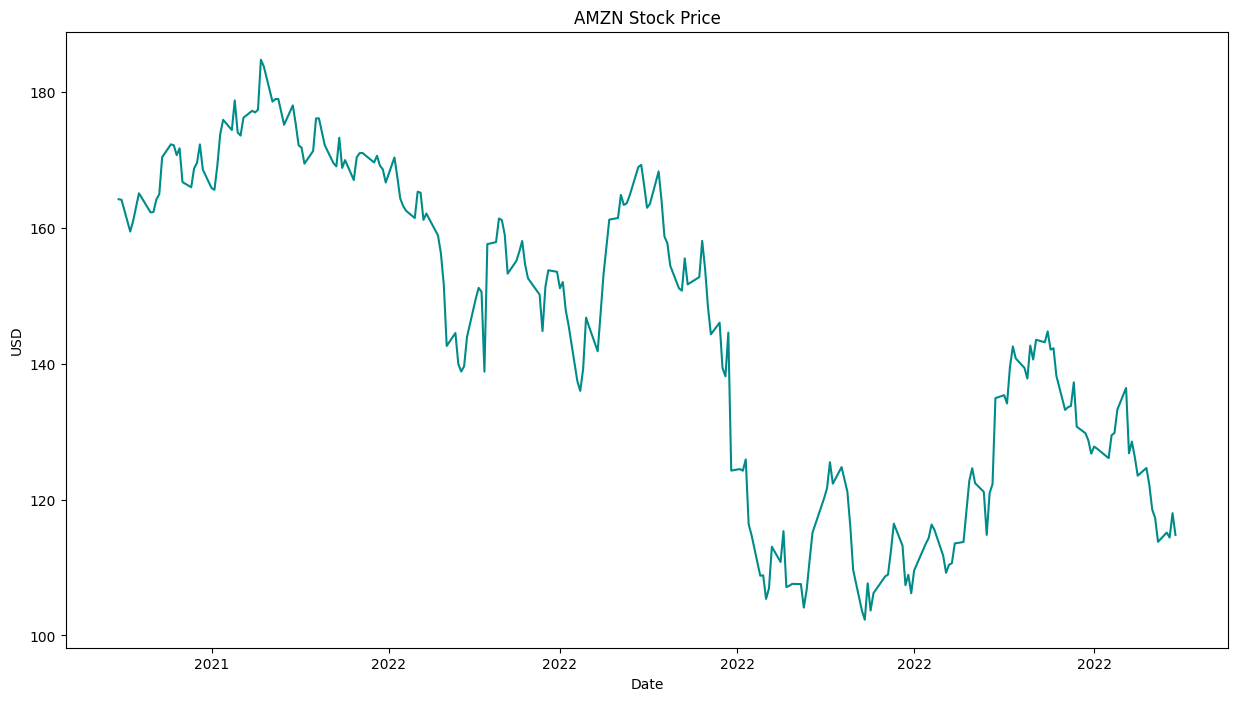

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


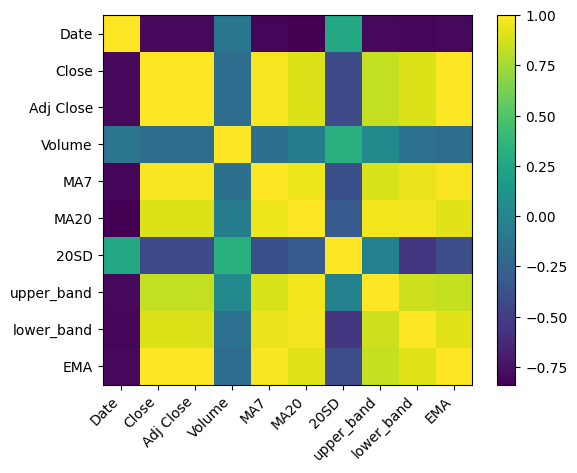

In [ ]:
tmp_df = dataset.drop(columns=['Open', 'High', 'Low', 'logmomentum', 'MACD'])
matrix = tmp_df.corr()

# plotting correlation matrix
plt.imshow(matrix)

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

plt.savefig('corr_matrix.png')

# Display the plot
plt.show()

In [ ]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    scaler = MinMaxScaler(feature_range=(-1, 1))

    c1 = scaler.fit_transform(dataset[['sentiment_score']])
    c2 = scaler.fit_transform(dataset[['Adj Close']])
#     c1 = (c1 - c1.min()) / (c1.max() - c1.min())
#     c2 = (c2 - c2.min()) / (c2.max() - c2.min())

    ax.plot(dataset['Date'], c1, label='Sentiment Score', color='g', linestyle='--')

#     ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], c2, label='Closing Price', color='#6A5ACD')
#     ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
#     plt.title('Technical indicators')
    plt.ylabel('Normalized Value')
    plt.xlabel("Year")
    plt.legend()

    plt.savefig('closing_vs_sentscore.png')

    plt.show()

In [ ]:
print(tech_df.shape)

(252, 15)


In [ ]:
# Assuming 'final_df' has a column named 'sentiment_score',
# make sure 'get_tech_ind' function either keeps or adds this column to 'tech_df'.

# Check the columns of 'tech_df' after calling 'get_tech_ind' to confirm.
print(tech_df.columns)

# If 'sentiment_score' is not present, adjust 'get_tech_ind' accordingly.

# If 'sentiment_score' is present in 'tech_df', then the issue is likely
# with how 'dataset' is created. Ensure 'sentiment_score' is included in 'dataset':

dataset = tech_df.iloc[20:,:].reset_index(drop=True)  # This line was likely the culprit
# Check if 'sentiment_score' is in the columns of 'dataset'
print(dataset.columns)
# If not, you might need to modify this line to keep the necessary columns
# For example, if you want to keep all columns from 'tech_df':
dataset = tech_df.iloc[20:,:].reset_index(drop=True) # Keep all columns



Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA7',
       'MA20', 'MACD', '20SD', 'upper_band', 'lower_band', 'EMA',
       'logmomentum'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA7',
       'MA20', 'MACD', '20SD', 'upper_band', 'lower_band', 'EMA',
       'logmomentum'],
      dtype='object')


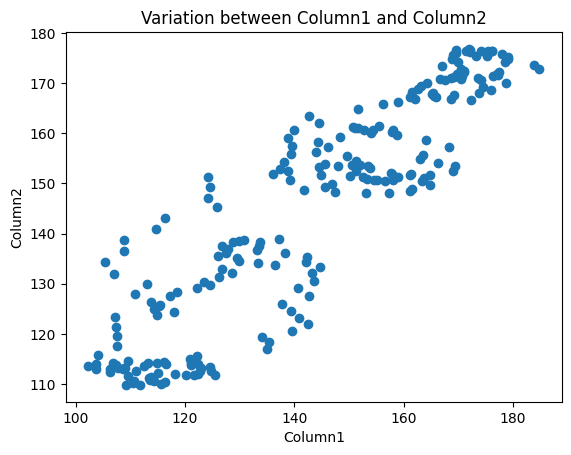

In [ ]:
plt.scatter(dataset['Close'], dataset['MA20'])
plt.xlabel('Column1')
plt.ylabel('Column2')
plt.title('Variation between Column1 and Column2')
plt.show()

In [ ]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [ ]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [ ]:
print(dataset.shape)

(232, 14)


In [ ]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [ ]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC  # SVM is generally referenced with SVC in sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X_scale_dataset, y_scale_dataset, test_size=0.3, random_state=42)
# X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
# print("X shape:", X_batched.shape)
# print("y shape:", y_batched.shape)
# print("yc shape:", yc.shape)

# X_train, X_test, = split_train_test(X_batched)
# y_train, y_test, = split_train_test(y_batched)
# yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, X_train.shape[0], 1)

input_dim = X_train.shape[1]
feature_size = X_train.shape[1]
output_dim = y_train.shape[1]

In [ ]:
def plot_test_data_custom(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    Predicted_test_price = Predicted_test_price.reshape(-1, 1)

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    # print(rescaled_Real_price)
    # print(rescaled_Predicted_price)

    # predict_result = pd.DataFrame()
    # for i in range(rescaled_Predicted_price.shape[0]):
    #     y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
    #     predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    # real_price = pd.DataFrame()
    # for i in range(rescaled_Real_price.shape[0]):
    #     y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
    #     real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    # predict_result['predicted_mean'] = predict_result.mean(axis=1)
    # real_price['real_mean'] = real_price.mean(axis=1)

    idx = np.random.randint(rescaled_Predicted_price.shape[0], size=15)

    predicted = rescaled_Predicted_price[idx]
    real = rescaled_Real_price[idx]
    # For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    mse = mean_squared_error(predicted, real)
    mae = mean_absolute_error(predicted, real)
    print('Test RMSE: ', RMSE)
    print('Test MSE:', mse)
    print('Test MAE:', mae)

    plt.figure(figsize=(16, 8))
    plt.plot(real, color='#00008B')
    plt.plot(predicted, color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

Test RMSE:  0.570397678570593
Test MSE: 0.3253535117187215
Test MAE: 0.4630375900268594


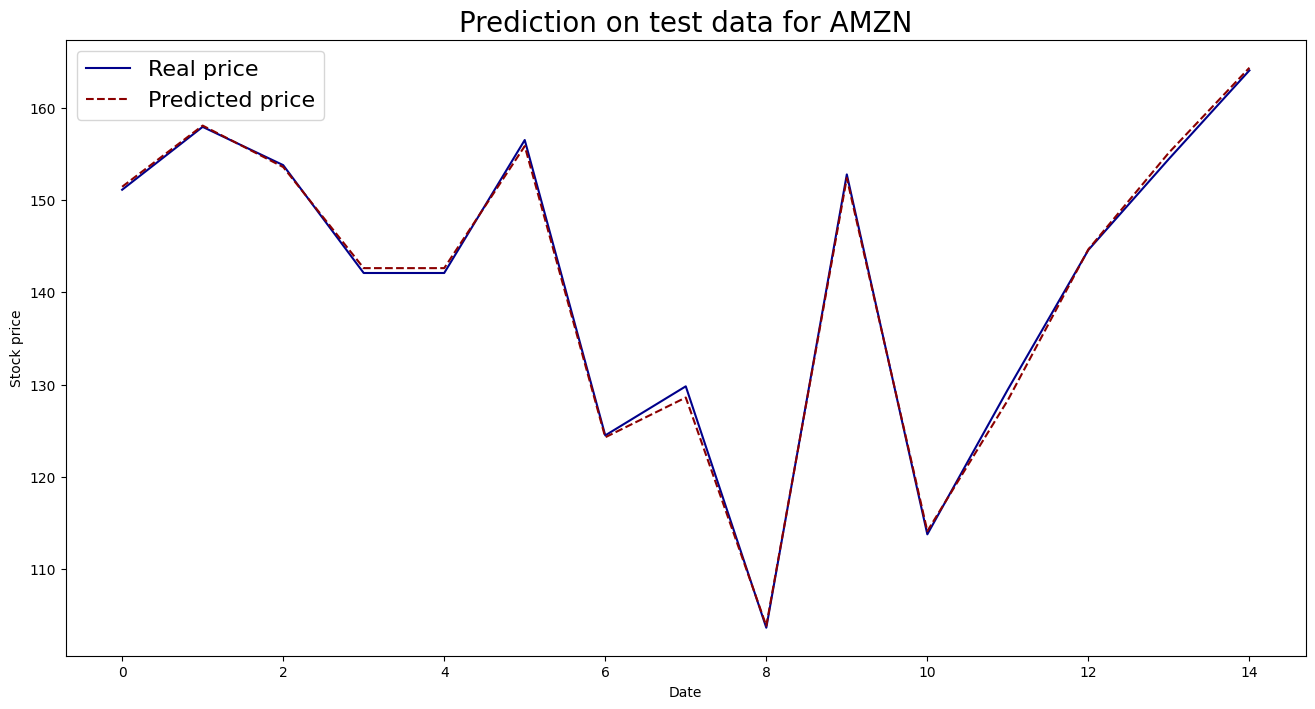

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize and fit GridSearchCV for Random Forest
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Retrieve best model and predictions
best_rf_model = rf_grid.best_estimator_
rf_predictions = best_rf_model.predict(X_test)

plot_test_data_custom(y_test, rf_predictions, index_test)

Ridge Regression - Best Params: {'alpha': 0.1}
Test RMSE:  1.7308359910870799
Test MSE: 2.9957932280423942
Test MAE: 0.7794956665039042


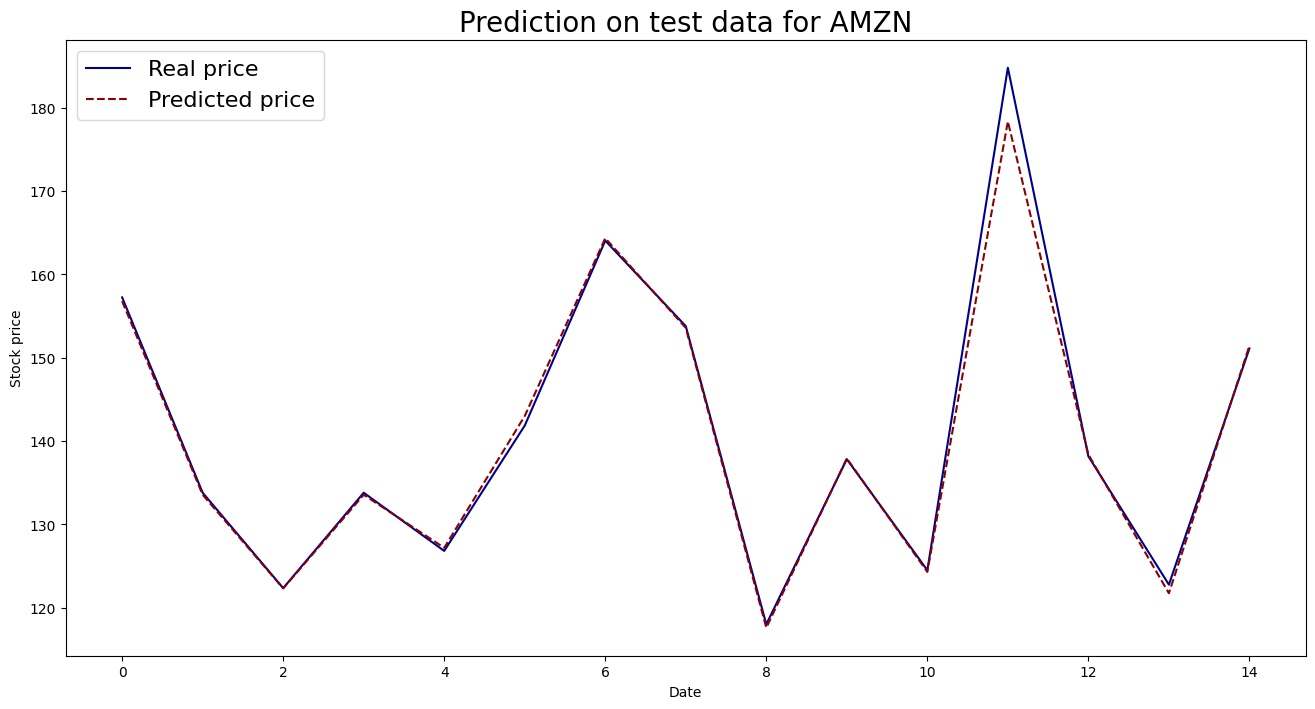

In [ ]:
# Define Ridge parameter grid
ridge_param_grid = {'alpha': [0.1, 1, 10, 100]}

# Initialize and fit GridSearchCV for Ridge
ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Retrieve best model and predictions
best_ridge_model = ridge_grid.best_estimator_
ridge_predictions = best_ridge_model.predict(X_test)

print(f'Ridge Regression - Best Params: {ridge_grid.best_params_}')
# print(f'Ridge Regression - MSE: {ridge_mse}, MAE: {ridge_mae}, RMSE: {ridge_rmse}')

plot_test_data_custom(y_test, rf_predictions, index_test)

Test RMSE:  25.611457694993405
Test MSE: 655.9467652624369
Test MAE: 22.300062561035173


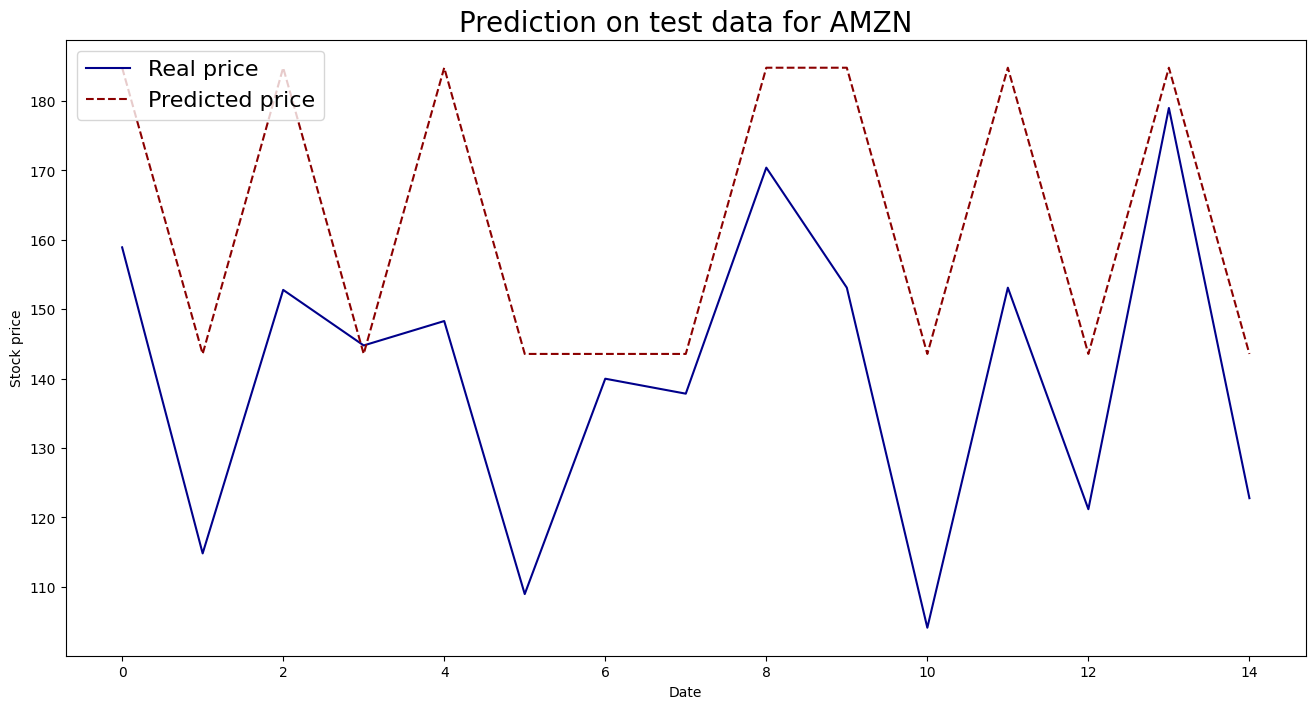

In [ ]:
# SVM Model (for classification)
threshold = 0
y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Define SVM parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 1]
}

# Initialize and fit GridSearchCV for SVM
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train_binary)

# Retrieve best model and predictions
best_svm_model = svm_grid.best_estimator_
svm_predictions = best_svm_model.predict(X_test)

plot_test_data_custom(y_test, svm_predictions, index_test)

Test RMSE:  0.0
Test MSE: 0.0
Test MAE: 0.0


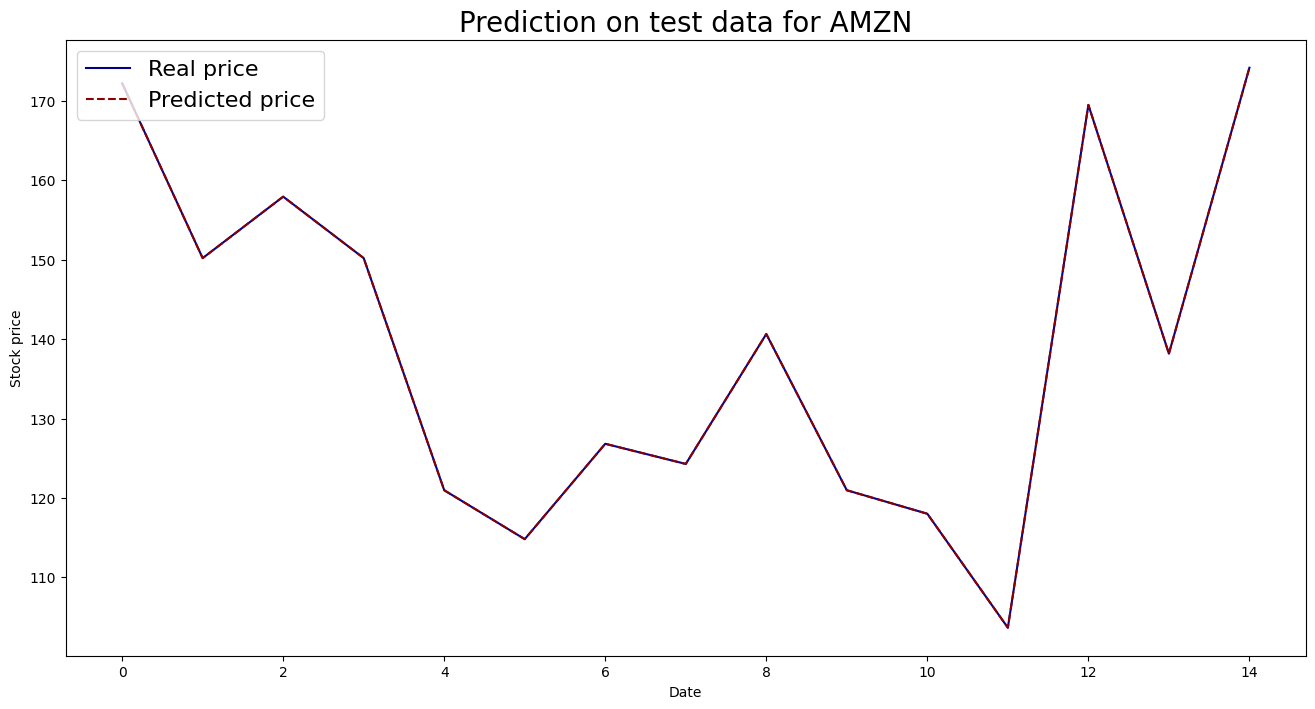

In [ ]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

plot_test_data_custom(y_test, lr_predictions, index_test)

Test RMSE:  2.117284282788587
Test MSE: 4.48289273414358
Test MAE: 1.7402073160807277


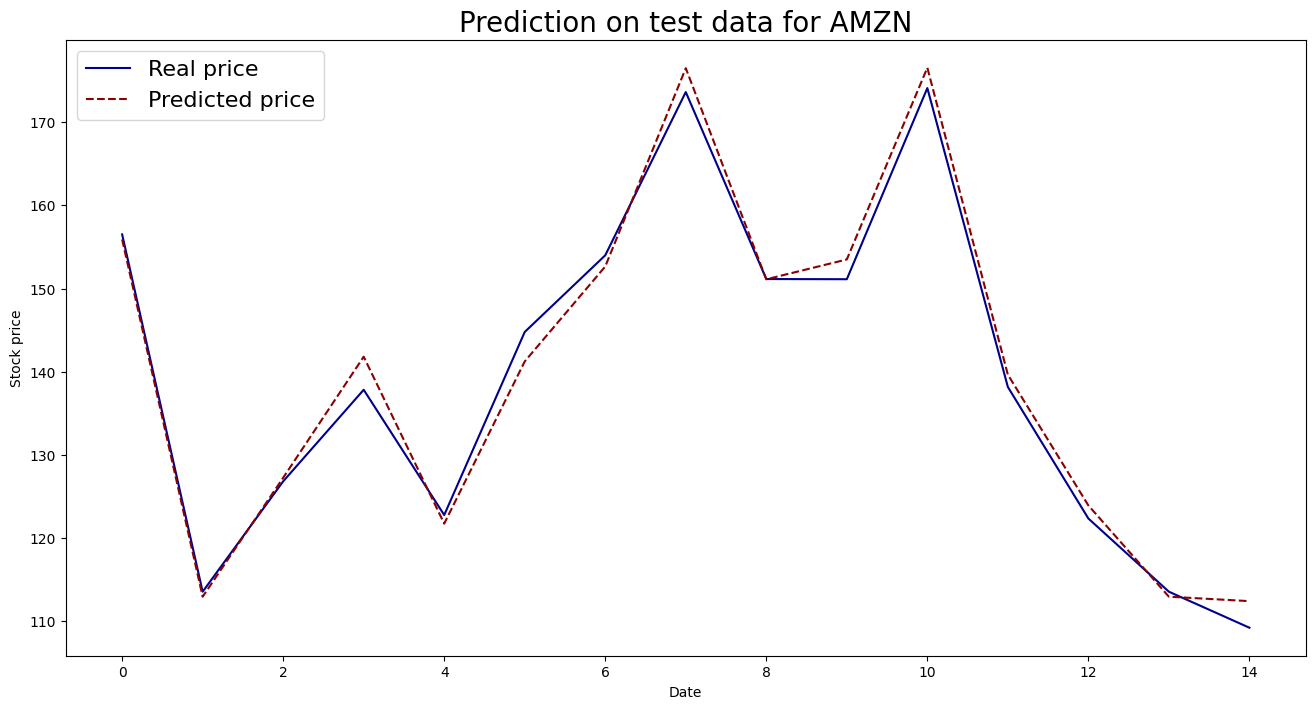

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# KNN algo
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed
knn.fit(X_train, y_train)

# Step 4: Make Predictions
knn_predictions = knn.predict(X_test)

plot_test_data_custom(y_test, knn_predictions, index_test)